# Project Description
This project takes a dataset of Wikipedia comments that have been labeled as toxic by humans and labels the comments with six given labels, toxic, severe toxic, obscene, threat, insult, and identity_hate. The output of the model used gives a probability prediction for each label for a given comment.

## Problem Statement: 
The aim of the project is to categorize the toxic comments based on the types of toxicity. 
Examples of toxicity types can be toxic, severely toxic, obscene, threat, insult, identity hate. Different machine learning techniques like Logistic Regression, Decision Tree, Light Gradient Boosting Machine (LightGBM) are implemented to determine the 6 types of toxic comments. 

## Dataset
Dataset Link: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

### Data characteristics
1. Number of data points 159571
2. Number data points of type toxic 15294 
3. Number data points of type severe_tocic 1595 
4. Number data points of type obscene 8449 
5. Number data points of type threat 478 
6. Number data points of type insult 7877 
7. Number data points of type identity_hate 1405 
8. Observations in one or more class 35098
8. Unclassified observation 124473

### Disclaimer: the dataset used in this course project contains text that may be considered profane, vulgar, or offensive.

## Importing required libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotnine import *
from matplotlib_venn import venn3, venn3_circles

import re
import logging
import itertools
import unicodedata
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
##import spacy nlp = spacy.load('en_core_web_sm')

# import contractions

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from IPython.display import Markdown as md

from wordsegment import load, segment
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score

from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import warnings
warnings.filterwarnings("ignore")

### Loading the Train Dataset

In [2]:
data = pd.read_csv('C:/Users/rajan/Documents/ElmhurstUniversity/MDS-564 Adv Data Mining&Analytics/W7/CourseProject/ToxicComments/Datasets/train.csv')

In [3]:
print("shape of train data : ", data.shape)
print("first 5 rows of train data :")
data.head()

shape of train data :  (159571, 8)
first 5 rows of train data :


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# Feature Imformation 
data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [5]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [6]:
# Check Missing Value 

print("There are :",(data["comment_text"].isna().sum()), "Missing values in the Dataset")

# dropna 

There are : 0 Missing values in the Dataset


## Sample comments corresponding to each category

In [7]:
for i in ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']:
    print("{} :".format(i.upper()))
    print(data.loc[data[i]==1, 'comment_text'].sample().values[0][:500], "\n")

TOXIC :
"

I call people ""idiots""WHEN THEY DO IDIOTIC THINGS (I already explained to you) - WITHOUT ATTEMPTING REACING A CONSENSUS (reverting repeatedly without discussing, and usually not replying when I try to discuss).   " 

SEVERE_TOXIC :
George Washington 

I heard that mother fucker had like... 30 god damn dicks... 

OBSCENE :
Knock off the gosh darn vandalism! 

If you keep on vandalising articles as you did to Poop I'm going to warn your ass.  This is a federal offense and you know what happens in prison.  ;)  You better watch yourself or I will unleash a powerful series of warnings.  I've got like a buttload of respect around here and I don't take kindly to people who come to these places and treat it like SHIT!  DX 

THREAT :
CALTLAS IF YOU CONTINUE TO RVV IT, I WILL BLANK YOUR TALK PAGE, I WILL BLOCK YOU, I WILL BAN YOU, AND I WILL KILL YOUCALTLAS IF YOU CONTINUE TO RVV IT, I WILL BLANK YOUR TALK PAGE, I WILL BLOCK YOU, I WILL BAN YOU, AND I WILL KILL YOUCALTLAS IF YOU CON

## Text cleaning

Next step is to remove unnecessary elements from text.

It is important to note that this "unnecessary text" elimination process could be more successful when followed in a particular sequence.

Here is the sequence we will implement:

- HTML codes (if present)
- URLs/ email addresses
- Hashtags/Usernames
- Emojis
- Stopwords
- Expanding Abbreviations
- Punctuations
- Special characters/ Numbers

In [8]:
## Text cleaning

import re

class TextCleaningUtils:
    '''
        This class contains implementations of various text cleaning operations (Static Methods)
    '''

    cleaning_regex_map = {
        'web_links': r'(?i)(?:(?:http(?:s)?:)|(?:www\.))\S+',
#         'special_chars': r'[^a-zA-Z0-9\s\.,!?;:]+',
        'special_chars': r'[^a-zA-Z\s\.,!?;:]+',  ## removing nums
        'redundant_spaces': r'\s\s+',
        'redundant_newlines': r'[\r|\n|\r\n]+',
        'twitter_handles': r'[#@]\S+',
        'punctuations': r'[\.,!?;:]+'
    }
    
    def expand_abbreviations(text):
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"there's", "there is", text)
        text = re.sub(r"We're", "We are", text)
        text = re.sub(r"That's", "That is", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"they're", "they are", text)
        text = re.sub(r"Can't", "Cannot", text)
        text = re.sub(r"wasn't", "was not", text)
        text = re.sub(r"don\x89Ûªt", "do not", text)
        text= re.sub(r"aren't", "are not", text)
        text = re.sub(r"isn't", "is not", text)
        text = re.sub(r"What's", "What is", text)
        text = re.sub(r"haven't", "have not", text)
        text = re.sub(r"hasn't", "has not", text)
        text = re.sub(r"There's", "There is", text)
        text = re.sub(r"He's", "He is", text)
        text = re.sub(r"It's", "It is", text)
        text = re.sub(r"You're", "You are", text)
        text = re.sub(r"I'M", "I am", text)
        text = re.sub(r"shouldn't", "should not", text)
        text = re.sub(r"wouldn't", "would not", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"i'm", "I am", text)
        text = re.sub(r"I\x89Ûªm", "I am", text)
        text = re.sub(r"I'm", "I am", text)
        text = re.sub(r"Isn't", "is not", text)
        text = re.sub(r"Here's", "Here is", text)
        text = re.sub(r"you've", "you have", text)
        text = re.sub(r"you\x89Ûªve", "you have", text)
        text = re.sub(r"we're", "we are", text)
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"we've", "we have", text)
        text = re.sub(r"it\x89Ûªs", "it is", text)
        text = re.sub(r"doesn\x89Ûªt", "does not", text)
        text = re.sub(r"It\x89Ûªs", "It is", text)
        text = re.sub(r"Here\x89Ûªs", "Here is", text)
        text = re.sub(r"who's", "who is", text)
        text = re.sub(r"I\x89Ûªve", "I have", text)
        text = re.sub(r"y'all", "you all", text)
        text = re.sub(r"can\x89Ûªt", "cannot", text)
        text = re.sub(r"would've", "would have", text)
        text = re.sub(r"it'll", "it will", text)
        text = re.sub(r"we'll", "we will", text)
        text = re.sub(r"wouldn\x89Ûªt", "would not", text)
        text = re.sub(r"We've", "We have", text)
        text = re.sub(r"he'll", "he will", text)
        text = re.sub(r"Y'all", "You all", text)
        text = re.sub(r"Weren't", "Were not", text)
        text = re.sub(r"Didn't", "Did not", text)
        text = re.sub(r"they'll", "they will", text)
        text = re.sub(r"DON'T", "DO NOT", text)
        text = re.sub(r"That\x89Ûªs", "That is", text)
        text = re.sub(r"they've", "they have", text)
        text = re.sub(r"they'd", "they would", text)
        text = re.sub(r"i'd", "I would", text)
        text = re.sub(r"should've", "should have", text)
        text = re.sub(r"You\x89Ûªre", "You are", text)
        text = re.sub(r"where's", "where is", text)
        text = re.sub(r"Don\x89Ûªt", "Do not", text)
        text = re.sub(r"i'll", "I will", text)
        text = re.sub(r"weren't", "were not", text)
        text = re.sub(r"They're", "They are", text)
        text = re.sub(r"Can\x89Ûªt", "Cannot", text)
        text = re.sub(r"you\x89Ûªll", "you will", text)
        text = re.sub(r"I\x89Ûªd", "I would", text)
        text = re.sub(r"let's", "let us", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"can't", "cannot", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"you're", "you are", text)
        text = re.sub(r"i've", "I have", text)
        text = re.sub(r"that's", "that is", text)
        text = re.sub(r"i'll", "I will", text)
        text = re.sub(r"doesn't", "does not",text)
        text = re.sub(r"i'd", "I would", text)
        text = re.sub(r"didn't", "did not", text)
        text = re.sub(r"ain't", "am not", text)
        text = re.sub(r"you'll", "you will", text)
        text = re.sub(r"I've", "I have", text)
        text = re.sub(r"Don't", "do not", text)
        text = re.sub(r"I'll", "I will", text)
        text = re.sub(r"I'd", "I would", text)
        text = re.sub(r"Let's", "Let us", text)
        text = re.sub(r"you'd", "You would", text)
        text = re.sub(r"It's", "It is", text)
        text = re.sub(r"Ain't", "am not", text)
        text = re.sub(r"Haven't", "Have not", text)
        text = re.sub(r"Hadn't", "Had not", text)
        text = re.sub(r"Could've", "Could have", text)
        text = re.sub(r"youve", "you have", text)  
        text = re.sub(r"donå«t", "do not", text)  

        return text
    
    def remove_emojis(text):
        emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text=emoji_clean.sub(r'',text)
        url_clean= re.compile(r"https://\S+|www\.\S+")
        text=url_clean.sub(r'',text)
        return text
    
#     def remove_punctuations(text):
#         punct_tag=re.compile(r'[^\w\s]')
#         text=punct_tag.sub(r'',text)
#         return text

    @staticmethod
    def clean_text_from_regex(text, text_clean_regex):
        '''
            Follow a particular cleaning expression, provided
            as an input by an user to clean the text.
        '''

        text = text_clean_regex.sub(' ', text).strip()
        return text

    @staticmethod
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

    @staticmethod
    def remove_special_chars(text):
        '''
            Replace any special character provided as default,
            which is present in the text with space
        '''

        special_chars_regex = re.compile(TextCleaningUtils.cleaning_regex_map['special_chars'])
        text = TextCleaningUtils.clean_text_from_regex(text, special_chars_regex)
        return text

    @staticmethod
    def remove_redundant_spaces(text):
        '''
            Remove any redundant space provided as default,
            that is present in the text.
        '''

        redundant_spaces_regex = re.compile(
            TextCleaningUtils.cleaning_regex_map['redundant_spaces'])
        text = TextCleaningUtils.clean_text_from_regex(text, redundant_spaces_regex)
        return text

    @staticmethod
    def remove_web_links(text):
        '''
            Removes any web link that follows a particular default expression,
            present in the text.
        '''

        web_links_regex = re.compile(TextCleaningUtils.cleaning_regex_map['web_links'])
        text = TextCleaningUtils.clean_text_from_regex(text, web_links_regex)
        return text

    @staticmethod
    def remove_twitter_handles(text):
        '''
            Removes any twitter handle present in the text.
        '''

        twitter_handles_regex = re.compile(TextCleaningUtils.cleaning_regex_map['twitter_handles'])
        text = TextCleaningUtils.clean_text_from_regex(text, twitter_handles_regex)
        return text

    @staticmethod
    def remove_redundant_newlines(text):
        '''
            Removes any redundant new line present in the text.
        '''

        redundant_newlines_regex = re.compile(
            TextCleaningUtils.cleaning_regex_map['redundant_newlines'])
        text = TextCleaningUtils.clean_text_from_regex(text, redundant_newlines_regex)
        return text

    @staticmethod
    def remove_punctuations(text):
        '''
            Removes any punctuation that follows the default expression, in the text.
        '''

        remove_punctuations_regex = re.compile(TextCleaningUtils.cleaning_regex_map['punctuations'])
        text = TextCleaningUtils.clean_text_from_regex(text, remove_punctuations_regex)
        return text

    @staticmethod
    def remove_exaggerated_words(text):
        '''
            Removes any exaggerated word present in the text.
        '''

        return ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))

    @staticmethod
    def replace_multiple_chars(text):
        '''
            Replaces multiple characters present in the text.
        '''

        char_list = ['.', '?', '!', '#', '$', '/', '@', '*', '(', ')', '+']
        final_text = ''
        for i in char_list:
            if i in text:
                pattern = "\\" + i + '{2,}'
                repl_str = i.replace("\\", "")
                text = re.sub(pattern, repl_str, text)
                final_text = ' '.join(text.split())
        return final_text

    @staticmethod
    def replace_sign(text):
        '''
            Replaces any sign with words like & with 'and', in the text.
        '''
        sign_list = {'&': ' and ', '/': ' or ', '\xa0': ' '}
        final_text = ''
        for i in sign_list:
            if i in text:
                text = re.sub(i, sign_list[i], text)
                final_text = ' '.join(text.split())
        return final_text

    @staticmethod
    def remove_accented_char(text):
        text = unicodedata.normalize('NFD', text) \
            .encode('ascii', 'ignore') \
            .decode("utf-8")
        return str(text)

    @staticmethod
    def replace_characters(text, replace_map):
        '''
            Replaces any character custom provided by an user.
        '''

        for char, replace_val in replace_map.items():
            text = text.replace(char, replace_val)
        return text
    
def clean_data(df,col_to_clean):
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.expand_abbreviations)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_emojis)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_special_chars)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_redundant_spaces)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_punctuations)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_exaggerated_words)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_redundant_newlines)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_twitter_handles)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_web_links)
    df[col_to_clean] = df[col_to_clean].astype(str)
    df[col_to_clean] = df[col_to_clean].str.lower()
    
    return df

In [9]:
%%time
data = clean_data(data, 'comment_text')

Wall time: 56.3 s


In [10]:
data['clean'] = np.where((data['toxic']==0) & (data['severe_toxic']==0) & (data['obscene']==0) & (data['threat']==0) & (data['insult']==0) & (data['identity_hate']==0), 1,0)

In [11]:
data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,d aww he matches this background colour i am ...,0,0,0,0,0,0,1
2,000113f07ec002fd,hey man i am really not trying to edit war i...,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,1
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0,0,0,0,0,0,1
5,00025465d4725e87,congratulations from me as well use the tools...,0,0,0,0,0,0,1
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0,0
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


# Exploratory Data Analysis

In [12]:
## preparing plots for the EDA :

plt.style.use("seaborn-pastel")
def category_percentage(df):
    df['clean'] = np.where((df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0), 1,0)
    
    categories = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean']
    plot_data = df[categories].mean()*100

    plt.figure(figsize=(10,5))
    plt.title("percentage records by category")
    sns.barplot(x=plot_data.index, y = plot_data.values)
    plt.show()
    
    return

def text_length_across_classes(df):
    df['comment_length'] = df['comment_text'].apply(lambda x : len(x.split()))
    
    median_text_len = []
    mean_text_len = []
    min_text_len = []
    max_text_len = []
    max_distinct_tokens = []
    
    for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
        mean_text_len.append(df[df[i]==1]['comment_length'].mean())  
        min_text_len.append(df[df[i]==1]['comment_length'].min())  
        max_text_len.append(df[df[i]==1]['comment_length'].max())  
        median_text_len.append(df[df[i]==1]['comment_length'].median())  
        df['distinct_tokens'] = df['comment_text'].apply(lambda x : len(set(x.split())))
        max_distinct_tokens.append(df[df[i]==1]['distinct_tokens'].max())
        
    mean_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].mean())
    min_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].min())
    max_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].max())
    median_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].median())
    max_distinct_tokens.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['distinct_tokens'].max())
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    sns.barplot(ax=axes[0,0], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=median_text_len)
    axes[0,0].set_title('median text length')
    sns.barplot(ax=axes[0,1], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=min_text_len)
    axes[0,1].set_title('minimum text length')
    sns.barplot(ax=axes[1,0], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=max_text_len)
    axes[1,0].set_title('max text length')
    sns.barplot(ax=axes[1,1], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=max_distinct_tokens)
    axes[1,1].set_title('max distinct tokens')

    fig.suptitle('text length statistics')
    plt.show()
    
    return 

def corr_between_labels(df):
    plt.figure(figsize=(15,8))
    plt.title("correlation between toxic categories")
    sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
    plt.show()
    return 

## Gram statistics
def gram_analysis(data,gram):
    stop_words_set = set(stopwords.words('english'))
    tokens=[t for t in data.lower().split(" ") if t!="" if t not in stop_words_set]
    ngrams=zip(*[tokens[i:] for i in range(gram)])
    final_tokens=[" ".join(z) for z in ngrams]
    return final_tokens

def gram_freq(df, gram, categ_col, text_col):
    category_text = " ".join(df[df[categ_col]==1][text_col].sample(200).values)
    toks = gram_analysis(category_text, gram)
    tok_freq = pd.DataFrame(data=[toks, np.ones(len(toks))]).T.groupby(0).sum().reset_index()
    tok_freq.columns = ['token','frequency']
    tok_freq = tok_freq.sort_values(by='frequency',ascending=False)
    
    plt.figure(figsize=(10,8))
    plt.title("{} most common tokens".format(categ_col))
    sns.barplot(x='token', y='frequency', data=tok_freq.iloc[:30])
    plt.xticks(rotation=90)
    plt.show()
    
    return 

def avg_word_len_plot(df):
    # word distribution across categories
    df['punct_count'] = df['comment_text'].apply(lambda x : len([a for a in x if a in string.punctuation]))
    df['avg_word_length'] = df['comment_text'].apply(lambda x : np.round(np.mean([len(a) for a in x.split()])))
    
    clean = df[df['clean']==1].avg_word_length.value_counts().reset_index()
    clean.columns = ['length', 'frequency']
    print("clean comments max token length : {}".format(max(clean.length)))
    clean = clean.sort_values(by='length')
    plt.figure(figsize=(20,7))
    plt.title("Average word length - clean comments")
    sns.barplot(x=clean.length, y=clean.frequency)
    plt.xticks(rotation = 90)
    plt.show()

    toxic = df[df['clean']==0].avg_word_length.value_counts().reset_index()
    toxic.columns = ['length', 'frequency']
    print("toxic comments max token length : {}".format(max(toxic.length)))
    toxic = toxic.sort_values(by='length')
    plt.figure(figsize=(20,7))
    plt.title("Average word length -toxic comments (all forms)")
    sns.barplot(x=toxic.length, y=toxic.frequency)
    plt.xticks(rotation = 90)
    plt.show()
    
    return 

def generate_wordclouds(df, text_col, categ_col):
    df['clean'] = np.where((df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0), 1,0)
    
    if categ_col=='all_toxic':
        category_text = df[df['clean']!=1][text_col].values
    else:
        category_text = df[df[categ_col]==1][text_col].values
               
    plt.figure(figsize=(15,8))
    wc = WordCloud(background_color="black", 
                   max_words=5000, 
                   stopwords=STOPWORDS, 
                   collocations=False,
                   max_font_size= 40)
    wc.generate(" ".join(category_text))
    plt.title("{} word cloud".format(categ_col), fontsize=20)
    # plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
    plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
    plt.axis('off')
    
    plt.show()
    
    return 

def venn_(df):
    figure, axes = plt.subplots(2,2,figsize=(20,20))
    toxic = set(df[df['toxic']==1].index)
    severe_toxic = set(df[df['severe_toxic']==1].index)
    obscene = set(df[df['obscene']==1].index)
    threat = set(df[df['threat']==1].index)
    insult = set(df[df['insult']==1].index)
    identity_hate = set(df[df['identity_hate']==1].index)
    clean = set(df[df['clean']==1].index)

    v1 = venn3([toxic, severe_toxic, obscene],
          set_labels=('Toxic','Severe toxic','Obscene'), set_colors=('#a5e6ff', '#3c8492','#9D8189'), ax=axes[0][0])
    for text in v1.set_labels:
        text.set_fontsize(22)
    v2 = venn3([threat, insult, identity_hate],
          set_labels=('Threat','Insult','Identity hate'), set_colors=('#e196ce', '#F29CB7','#3c81a9'), ax=axes[0][1])
    for text in v2.set_labels:
        text.set_fontsize(22)
    v3 = venn3([toxic, insult, obscene],
          set_labels=('Toxic','Insult','Obscene'), set_colors=('#a5e6ff', '#F29CB7','#9D8189'), ax=axes[1][0])
    for text in v3.set_labels:
        text.set_fontsize(22)
    v4 = venn3([threat, identity_hate, obscene],
          set_labels=('Threat','Identity hate','Obscene'), set_colors=('#e196ce', '#3c81a9','#9D8189'), ax=axes[1][1])
    for text in v4.set_labels:
        text.set_fontsize(22)
    plt.show()
    
    # deleting used variables
    del toxic
    del severe_toxic
    del obscene
    del threat
    del insult
    del identity_hate
    del clean
    
    return

def meta_data_analysis(df, text_col):
    meta_df = pd.DataFrame()
    meta_df['punctuations'] = df[text_col].apply(lambda x : len([a for a in str(x) if a in string.punctuation]))
    meta_df['hashtags'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith("#")]))
    meta_df['usernames'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith("@")]))
    meta_df['stop_words'] = df[text_col].apply(lambda x : len([a for a in x.lower().split() if a in STOPWORDS]))
    meta_df['upper_case_words'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.isupper()]))
    meta_df['urls'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith(tuple(['http', 'www']))]))
    meta_df['word_count'] = df[text_col].apply(lambda x : len(x.split()))
    meta_df['distinct_word_count'] = df[text_col].apply(lambda x : len(set(x.split())))
    meta_df['clean'] = df['clean'].copy()
    
    return meta_df

### Percentage of data vs Category

In [13]:
unlabelled_in_all = data[(data['toxic']!=1) & (data['severe_toxic']!=1) &
                             (data['obscene']!=1) & (data['threat']!=1) &
                             (data['insult']!=1) & (data['identity_hate']!=1)]
print('Percentage of unlabelled comments or good comments is ', len(unlabeled_in_all)/len(data)*100)

Percentage of unlabelled comments or good comments is  89.83211235124176


In [14]:
labelled_in_all = data[(data['toxic']==1) & (data['severe_toxic']==1) &
                             (data['obscene']==1) & (data['threat']==1) &
                             (data['insult']==1) & (data['identity_hate']==1)]
print('Percentage of comments which is present in all categories is ', len(labelled_in_all)/len(data)*100)

Percentage of comments which is present in all categories is  0.019427088882065038


In [15]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in train is {}'.format(len(data)))
print(data[cols_target].sum())

Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


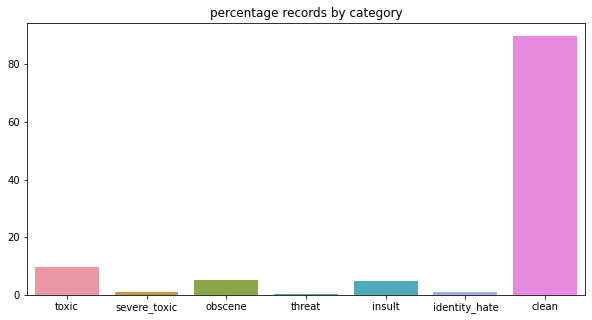

89.83% of the comments are clean i.e., non-toxic


In [16]:
category_percentage(data)
print("{}% of the comments are clean i.e., non-toxic".format(np.round(100*data['clean'].sum()/data.shape[0],2)))
perc_clean_data = np.round(100*data['clean'].sum()/data.shape[0],2)

### Data is highly imbalanced.

## Correlations among the target variables.

<AxesSubplot:title={'center':'Correlation of features & targets'}>

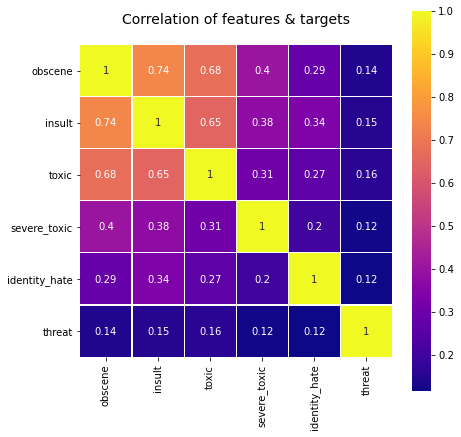

In [17]:
target_data = data[cols_target]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(target_data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

The correlation figure above shows that Toxic" comments are clearly correlated with both "obscene" and "insult" comments. Interestingly, "toxic" and "severe_toxic" are only weakly correlated. While we can also observe that, "Obscene" comments and "insult" comments are also highly correlated, which makes perfect sense.

## Further Cleaning of the Words

In [18]:
def clean_regex(word):
    lol_word = re.sub(
                r"""(?ix)\b    # assert position at a word boundary
                (?=lol)        # assert that "lol" can be matched here
                \S*            # match any number of characters except whitespace
                (\S+)          # match at least one character (to be repeated later)
                (?<=\blol)     # until we have reached exactly the position after the 1st "lol"
                \1*            # then repeat the preceding character(s) any number of times
                \b             # and ensure that we end up at another word boundary""", 
                "lol", word)
    if lol_word != word:
        return lol_word
                    
    fuck_word = re.sub(
        r"""(?ix)\b    # assert position at a word boundary
        (?=fuck)        # assert that "lol" can be matched here
        \S*            # match any number of characters except whitespace
        (\S+)          # match at least one character (to be repeated later)
        (?<=\bfuck)     # until we have reached exactly the position after the 1st "lol"
        \1*            # then repeat the preceding character(s) any number of times
        \b             # and ensure that we end up at another word boundary""", 
        "fuck", word)
    if fuck_word != word:
        return fuck_word
    
    haha_word = re.sub(
        r"""(?ix)\b    # assert position at a word boundary
        (?=haha)        # assert that "lol" can be matched here
        \S*            # match any number of characters except whitespace
        (\S+)          # match at least one character (to be repeated later)
        (?<=\bhaha)     # until we have reached exactly the position after the 1st "lol"
        \1*            # then repeat the preceding character(s) any number of times
        \b             # and ensure that we end up at another word boundary""", 
        "haha", word)
    if haha_word != word:
        return haha_word
    
    cunt_word = re.sub(
        r"""(?ix)\b    # assert position at a word boundary
        (?=cunt)        # assert that "lol" can be matched here
        \S*            # match any number of characters except whitespace
        (\S+)          # match at least one character (to be repeated later)
        (?<=\bcunt)     # until we have reached exactly the position after the 1st "lol"
        \1*            # then repeat the preceding character(s) any number of times
        \b             # and ensure that we end up at another word boundary""", 
        "cunt", word)
    if cunt_word != word:
        return cunt_word
    
    ty_word = re.sub(
        r"""(?ix)\b    # assert position at a word boundary
        (?=ty)        # assert that "lol" can be matched here
        \S*            # match any number of characters except whitespace
        (\S+)          # match at least one character (to be repeated later)
        (?<=\bty)     # until we have reached exactly the position after the 1st "lol"
        \1*            # then repeat the preceding character(s) any number of times
        \b             # and ensure that we end up at another word boundary""", 
        "ty", word)
    if ty_word != word:
        return ty_word
    return ''

In [19]:
def remove_repititative_char(sentence):
    clean_sentence = []
    for word in sentence.split():
        if len(word)>23:
            new_word = clean_regex(word)
            new_word = re.sub(r'([a-z])\1+', r'\1', word)
            print(word)
            print(new_word)
            clean_sentence.append(new_word)
        else:
            clean_sentence.append(word)
    return ' '.join(clean_sentence)
    
remove_repititative_char("fuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuck")


fuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuck
fuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuck


'fuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuck'

## Tokenizing and creating Word Clouds

### Tokenize and tag text

In [20]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

In [21]:
data['sentence']=data['comment_text'].apply(lambda x: sent_tokenize(x))

data['tokens']=data['comment_text'].apply(lambda x: word_tokenize(x))

In [22]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

def get_clean_token_list(words):
    clean_words=[]
    for word in words:
        flag=True
        for letter in word:
            if letter.isdigit() or letter in string.punctuation:
                flag=False
        if flag:
            clean_words.append(word)
    return clean_words

print(get_clean_token_list(["hewy","ho!w","are","yo6u","?dd","111","qwerty"]))

def remove_stopwords(words):
    """
    pass series get series
    """
    filtered_sent=[]
    for word in words:
        if word not in stop_words:
            filtered_sent.append(word)
    return filtered_sent


print(remove_stopwords(["hey","how","are","you","?"]))

['hewy', 'are', 'qwerty']
['hey', '?']


In [23]:
from nltk.stem.porter import PorterStemmer 
##Stemming is the process of converting inflected/derived words to their word stem or the root form. 
from nltk.stem.wordnet import WordNetLemmatizer
##Lemmatising is the process of grouping together the inflected forms of a word so they can be analyzed as a single item.

In [24]:
stem = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

def stem_sentence(sentence):
    stem_sentence=[]
    for word in sentence:
        stem_sentence.append(stem.stem(word))
    return stem_sentence

def lemmatize_sentence(sentence):
    lem_sentence=[]
    for word in sentence:
        lem_sentence.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    return lem_sentence

In [25]:
data['stem_sentence']=data['tokens'].apply(lambda x: stem_sentence(x))

data['lemm_sentence']=data['tokens'].apply(lambda x: lemmatize_sentence(x))

In [26]:
data[['tokens','stem_sentence']].head(10)

,tokens,stem_sentence
0,"[explanation, why, the, edits, made, under, my...","[explan, whi, the, edit, made, under, my, user..."
1,"[d, aww, he, matches, this, background, colour...","[d, aww, he, match, thi, background, colour, i..."
2,"[hey, man, i, am, really, not, trying, to, edi...","[hey, man, i, am, realli, not, tri, to, edit, ..."
3,"[more, i, can, not, make, any, real, suggestio...","[more, i, can, not, make, ani, real, suggest, ..."
4,"[you, sir, are, my, hero, any, chance, you, re...","[you, sir, are, my, hero, ani, chanc, you, rem..."
5,"[congratulations, from, me, as, well, use, the...","[congratul, from, me, as, well, use, the, tool..."
6,"[cocksucker, before, you, piss, around, on, my...","[cocksuck, befor, you, piss, around, on, my, w..."
7,"[your, vandalism, to, the, matt, shirvington, ...","[your, vandal, to, the, matt, shirvington, art..."
8,"[sorry, if, the, word, nonsense, was, offensiv...","[sorri, if, the, word, nonsens, wa, offens, to..."
9,"[alignment, on, this, subject, and, which, are...","[align, on, thi, subject, and, which, are, con..."


In [27]:
data[['tokens','lemm_sentence']].head(10)

,tokens,lemm_sentence
0,"[explanation, why, the, edits, made, under, my...","[explanation, why, the, edit, make, under, my,..."
1,"[d, aww, he, matches, this, background, colour...","[d, aww, he, match, this, background, colour, ..."
2,"[hey, man, i, am, really, not, trying, to, edi...","[hey, man, i, be, really, not, try, to, edit, ..."
3,"[more, i, can, not, make, any, real, suggestio...","[more, i, can, not, make, any, real, suggestio..."
4,"[you, sir, are, my, hero, any, chance, you, re...","[you, sir, be, my, hero, any, chance, you, rem..."
5,"[congratulations, from, me, as, well, use, the...","[congratulations, from, me, as, well, use, the..."
6,"[cocksucker, before, you, piss, around, on, my...","[cocksucker, before, you, piss, around, on, my..."
7,"[your, vandalism, to, the, matt, shirvington, ...","[your, vandalism, to, the, matt, shirvington, ..."
8,"[sorry, if, the, word, nonsense, was, offensiv...","[sorry, if, the, word, nonsense, be, offensive..."
9,"[alignment, on, this, subject, and, which, are...","[alignment, on, this, subject, and, which, be,..."


In [28]:
from nltk.probability import FreqDist

In [29]:
reviews=[word for review in data['lemm_sentence'] for word in review]

fdist_reviews = FreqDist(reviews)

fdist_reviews.most_common(20)

[('be', 527803),
 ('the', 497028),
 ('to', 297451),
 ('i', 240591),
 ('of', 224933),
 ('and', 224198),
 ('you', 218758),
 ('a', 217337),
 ('that', 160873),
 ('not', 152783),
 ('it', 148632),
 ('in', 145672),
 ('have', 132932),
 ('do', 112155),
 ('for', 102931),
 ('this', 97678),
 ('on', 89974),
 ('as', 77465),
 ('article', 74317),
 ('your', 63405)]

In [30]:
toxic_reviews=data[data['toxic']==1]['lemm_sentence']

toxic_tokens=[word for review in toxic_reviews for word in review]

fdist_toxic_tokens = FreqDist(toxic_tokens)

fdist_toxic_tokens.most_common(20)

[('be', 39368),
 ('you', 38934),
 ('i', 23316),
 ('the', 20599),
 ('a', 20529),
 ('and', 15769),
 ('to', 15683),
 ('fuck', 13445),
 ('of', 11426),
 ('not', 10153),
 ('do', 9558),
 ('your', 9145),
 ('that', 8239),
 ('it', 8194),
 ('have', 7365),
 ('in', 6787),
 ('my', 6184),
 ('me', 5557),
 ('this', 5498),
 ('on', 4885)]

### Most common Tokens

In [31]:
def get_most_common_tokens(df,label):
    label_reviews=df[df['toxic']==1]['lemm_sentence']
    label_tokens=[word for review in label_reviews for word in review]
    fdist_label_tokens = FreqDist(label_tokens)
    print(fdist_label_tokens.most_common(20))
    return fdist_label_tokens

In [32]:
data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean', 'sentence', 'tokens',
       'stem_sentence', 'lemm_sentence'],
      dtype='object')

In [33]:
severe_toxic_reviews=data[data['severe_toxic']==1]['lemm_sentence']

severe_toxic_tokens=[word for review in severe_toxic_reviews for word in review]

fdist_severe_toxic_tokens = FreqDist(severe_toxic_tokens)

fdist_severe_toxic_tokens.most_common(20)

[('you', 10738),
 ('fuck', 8802),
 ('be', 4619),
 ('i', 3700),
 ('suck', 3522),
 ('a', 3059),
 ('the', 2223),
 ('ass', 2115),
 ('your', 2056),
 ('shit', 1890),
 ('u', 1611),
 ('faggot', 1577),
 ('and', 1568),
 ('bitch', 1544),
 ('go', 1527),
 ('my', 1305),
 ('yourself', 1239),
 ('die', 1165),
 ('to', 1162),
 ('of', 1157)]

In [34]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,sentence,tokens,stem_sentence,lemm_sentence
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,1,[explanation why the edits made under my usern...,"[explanation, why, the, edits, made, under, my...","[explan, whi, the, edit, made, under, my, user...","[explanation, why, the, edit, make, under, my,..."
1,000103f0d9cfb60f,d aww he matches this background colour i am ...,0,0,0,0,0,0,1,[d aww he matches this background colour i am...,"[d, aww, he, matches, this, background, colour...","[d, aww, he, match, thi, background, colour, i...","[d, aww, he, match, this, background, colour, ..."
2,000113f07ec002fd,hey man i am really not trying to edit war i...,0,0,0,0,0,0,1,[hey man i am really not trying to edit war ...,"[hey, man, i, am, really, not, trying, to, edi...","[hey, man, i, am, realli, not, tri, to, edit, ...","[hey, man, i, be, really, not, try, to, edit, ..."
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,1,[more i cannot make any real suggestions on im...,"[more, i, can, not, make, any, real, suggestio...","[more, i, can, not, make, ani, real, suggest, ...","[more, i, can, not, make, any, real, suggestio..."
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0,0,0,0,0,0,1,[you sir are my hero any chance you remembe...,"[you, sir, are, my, hero, any, chance, you, re...","[you, sir, are, my, hero, ani, chanc, you, rem...","[you, sir, be, my, hero, any, chance, you, rem..."


#### Further tokenizing the text

In [35]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rajan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Parts of Speech Tagging and Lemmatization

In [36]:
data['pos_tag']=data['lemm_sentence'].apply(lambda x: nltk.pos_tag(x))

data['pos_tag'].head()

# The code takes significant amount of time to run

0    [(explanation, NN), (why, WRB), (the, DT), (ed...
1    [(d, NN), (aww, NN), (he, PRP), (match, VBZ), ...
2    [(hey, NN), (man, NN), (i, NN), (be, VB), (rea...
3    [(more, RBR), (i, NNS), (can, MD), (not, RB), ...
4    [(you, PRP), (sir, VBP), (be, VB), (my, PRP$),...
Name: pos_tag, dtype: object

In [37]:
keep_tags=["JJ","JJR","JJS","RB","RBR","RBS","UH","NN","NNS","NNP","NNPS"]

def filter_tag(pos_list):
    pos_clean_list=[]
    for t in pos_list:
        if t[1] in keep_tags:
            pos_clean_list.append(t[0])
    return pos_clean_list

filter_tag([('asked', 'RB'), ('review', 'NN'), ('scale', 'RBS')])

['asked', 'review', 'scale']

In [38]:
data['filter_pos_tag']=data['pos_tag'].apply(filter_tag)

data[['lemm_sentence','filter_pos_tag']].head(10)

,lemm_sentence,filter_pos_tag
0,"[explanation, why, the, edit, make, under, my,...","[explanation, edit, make, username, hardcore, ..."
1,"[d, aww, he, match, this, background, colour, ...","[d, aww, colour, i, seemingly, stick, thank, t..."
2,"[hey, man, i, be, really, not, try, to, edit, ...","[hey, man, i, really, not, war, just, guy, con..."
3,"[more, i, can, not, make, any, real, suggestio...","[more, i, not, real, suggestions, improvement,..."
4,"[you, sir, be, my, hero, any, chance, you, rem...","[hero, chance, page]"
5,"[congratulations, from, me, as, well, use, the...","[congratulations, well, tool, well]"
6,"[cocksucker, before, you, piss, around, on, my...","[cocksucker, around, work]"
7,"[your, vandalism, to, the, matt, shirvington, ...","[vandalism, matt, shirvington, article, revert..."
8,"[sorry, if, the, word, nonsense, be, offensive...","[sorry, word, nonsense, offensive, i, not, any..."
9,"[alignment, on, this, subject, and, which, be,...","[alignment, subject, contrary, dulithgow]"


In [39]:
data['clean_sentence']=data['filter_pos_tag'].apply(lambda x: ' '.join(x))

In [40]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,sentence,tokens,stem_sentence,lemm_sentence,pos_tag,filter_pos_tag,clean_sentence
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,1,[explanation why the edits made under my usern...,"[explanation, why, the, edits, made, under, my...","[explan, whi, the, edit, made, under, my, user...","[explanation, why, the, edit, make, under, my,...","[(explanation, NN), (why, WRB), (the, DT), (ed...","[explanation, edit, make, username, hardcore, ...",explanation edit make username hardcore metall...
1,000103f0d9cfb60f,d aww he matches this background colour i am ...,0,0,0,0,0,0,1,[d aww he matches this background colour i am...,"[d, aww, he, matches, this, background, colour...","[d, aww, he, match, thi, background, colour, i...","[d, aww, he, match, this, background, colour, ...","[(d, NN), (aww, NN), (he, PRP), (match, VBZ), ...","[d, aww, colour, i, seemingly, stick, thank, t...",d aww colour i seemingly stick thank talk janu...
2,000113f07ec002fd,hey man i am really not trying to edit war i...,0,0,0,0,0,0,1,[hey man i am really not trying to edit war ...,"[hey, man, i, am, really, not, trying, to, edi...","[hey, man, i, am, realli, not, tri, to, edit, ...","[hey, man, i, be, really, not, try, to, edit, ...","[(hey, NN), (man, NN), (i, NN), (be, VB), (rea...","[hey, man, i, really, not, war, just, guy, con...",hey man i really not war just guy constantly r...
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,1,[more i cannot make any real suggestions on im...,"[more, i, can, not, make, any, real, suggestio...","[more, i, can, not, make, ani, real, suggest, ...","[more, i, can, not, make, any, real, suggestio...","[(more, RBR), (i, NNS), (can, MD), (not, RB), ...","[more, i, not, real, suggestions, improvement,...",more i not real suggestions improvement i sect...
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0,0,0,0,0,0,1,[you sir are my hero any chance you remembe...,"[you, sir, are, my, hero, any, chance, you, re...","[you, sir, are, my, hero, ani, chanc, you, rem...","[you, sir, be, my, hero, any, chance, you, rem...","[(you, PRP), (sir, VBP), (be, VB), (my, PRP$),...","[hero, chance, page]",hero chance page


In [41]:
clean_reviews=data[(data['toxic']==0)&(data['severe_toxic']==0)&(data['obscene']==0)&(data['threat']==0)&(data['insult']==0)&(data['identity_hate']==0)]['filter_pos_tag']

clean_tokens=[word for review in clean_reviews for word in review]

fdist_clean_tokens = FreqDist(clean_tokens)

fdist_clean_tokens.most_common(20)

[('i', 185491),
 ('not', 141488),
 ('article', 72187),
 ('page', 52428),
 ('wikipedia', 34738),
 ('s', 32826),
 ('talk', 32784),
 ('edit', 29973),
 ('just', 25083),
 ('so', 24694),
 ('source', 23296),
 ('more', 22303),
 ('other', 21346),
 ('here', 20851),
 ('also', 19810),
 ('there', 19219),
 ('thank', 18923),
 ('please', 18328),
 ('time', 17961),
 ('people', 16815)]

In [42]:
def get_most_common_tokens(df,label):
    label_reviews=df[df[label]==1]['lemm_sentence']
    label_tokens=[word for review in label_reviews for word in review]
    fdist_label_tokens = FreqDist(label_tokens)
    print(fdist_label_tokens.most_common(20))
    return fdist_label_tokens

In [43]:
data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean', 'sentence', 'tokens',
       'stem_sentence', 'lemm_sentence', 'pos_tag', 'filter_pos_tag',
       'clean_sentence'],
      dtype='object')

In [44]:
label_list = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

In [45]:
for label in label_list:
    print(label.upper())
    get_most_common_tokens(data,label)

TOXIC
[('be', 39368), ('you', 38934), ('i', 23316), ('the', 20599), ('a', 20529), ('and', 15769), ('to', 15683), ('fuck', 13445), ('of', 11426), ('not', 10153), ('do', 9558), ('your', 9145), ('that', 8239), ('it', 8194), ('have', 7365), ('in', 6787), ('my', 6184), ('me', 5557), ('this', 5498), ('on', 4885)]
SEVERE_TOXIC
[('you', 10738), ('fuck', 8802), ('be', 4619), ('i', 3700), ('suck', 3522), ('a', 3059), ('the', 2223), ('ass', 2115), ('your', 2056), ('shit', 1890), ('u', 1611), ('faggot', 1577), ('and', 1568), ('bitch', 1544), ('go', 1527), ('my', 1305), ('yourself', 1239), ('die', 1165), ('to', 1162), ('of', 1157)]
OBSCENE
[('you', 23877), ('be', 18830), ('fuck', 13249), ('i', 12086), ('a', 11643), ('the', 10779), ('and', 8272), ('to', 7372), ('of', 5454), ('your', 5426), ('do', 4966), ('not', 4860), ('it', 4264), ('suck', 4196), ('that', 3945), ('my', 3668), ('in', 3609), ('have', 3524), ('shit', 3237), ('this', 2969)]
THREAT
[('i', 2109), ('you', 2033), ('die', 1178), ('be', 913)

In [46]:
from PIL import Image
def display_cloud(label):
    plt.subplots(figsize=(10,10))
    text = data[data[label]==1]["clean_sentence"].tolist()
    wc = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1500,
                         )
    wc.generate(' '.join(text))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(label,fontsize=36)
    plt.show()

### Displying the Word Clouds

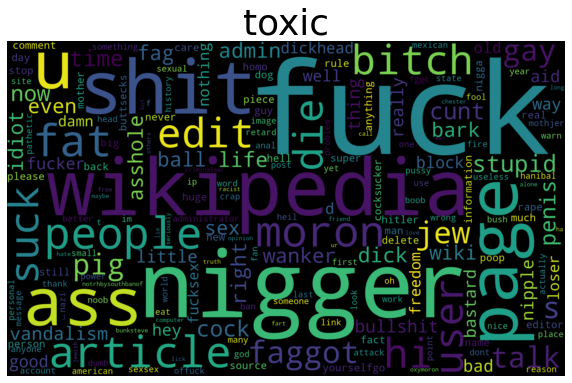

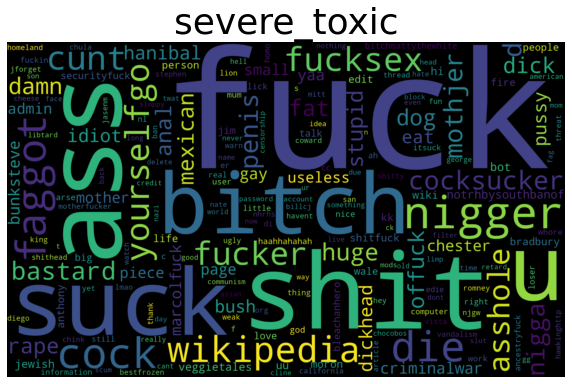

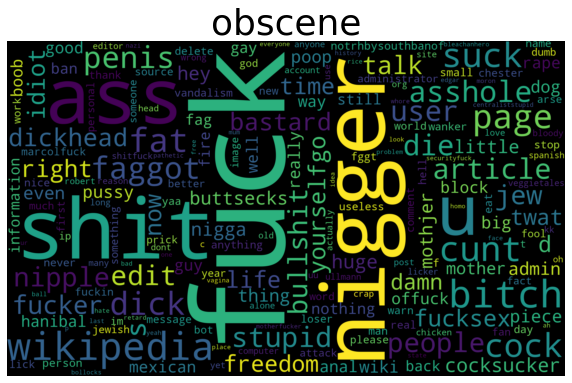

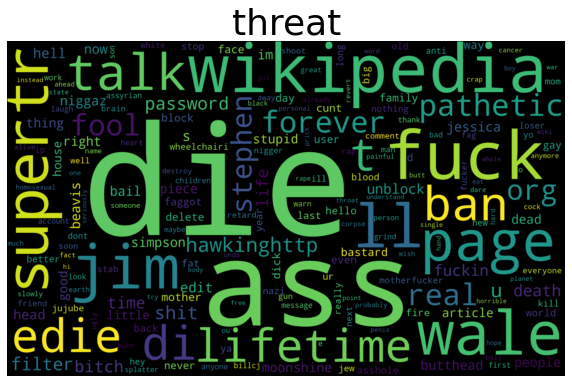

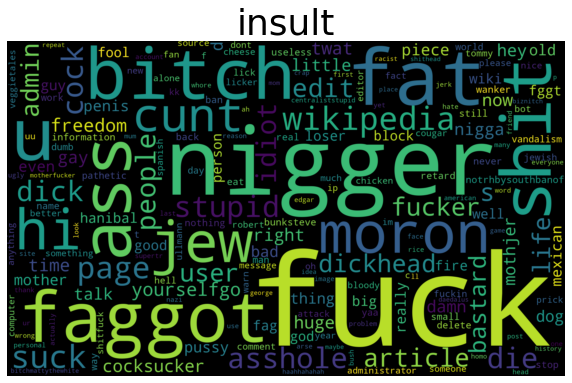

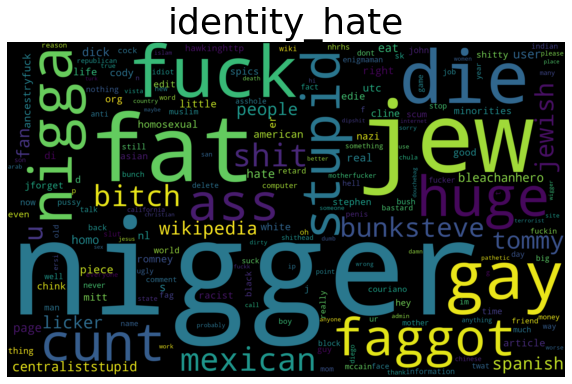

In [47]:
for label in label_list:
    display_cloud(label)

### Interrelation between categories

- All severe toxic comments are toxic
- Most severe toxic comments are also obscene in nature
- toxic, insult and obscene comments share a good amount of overlap

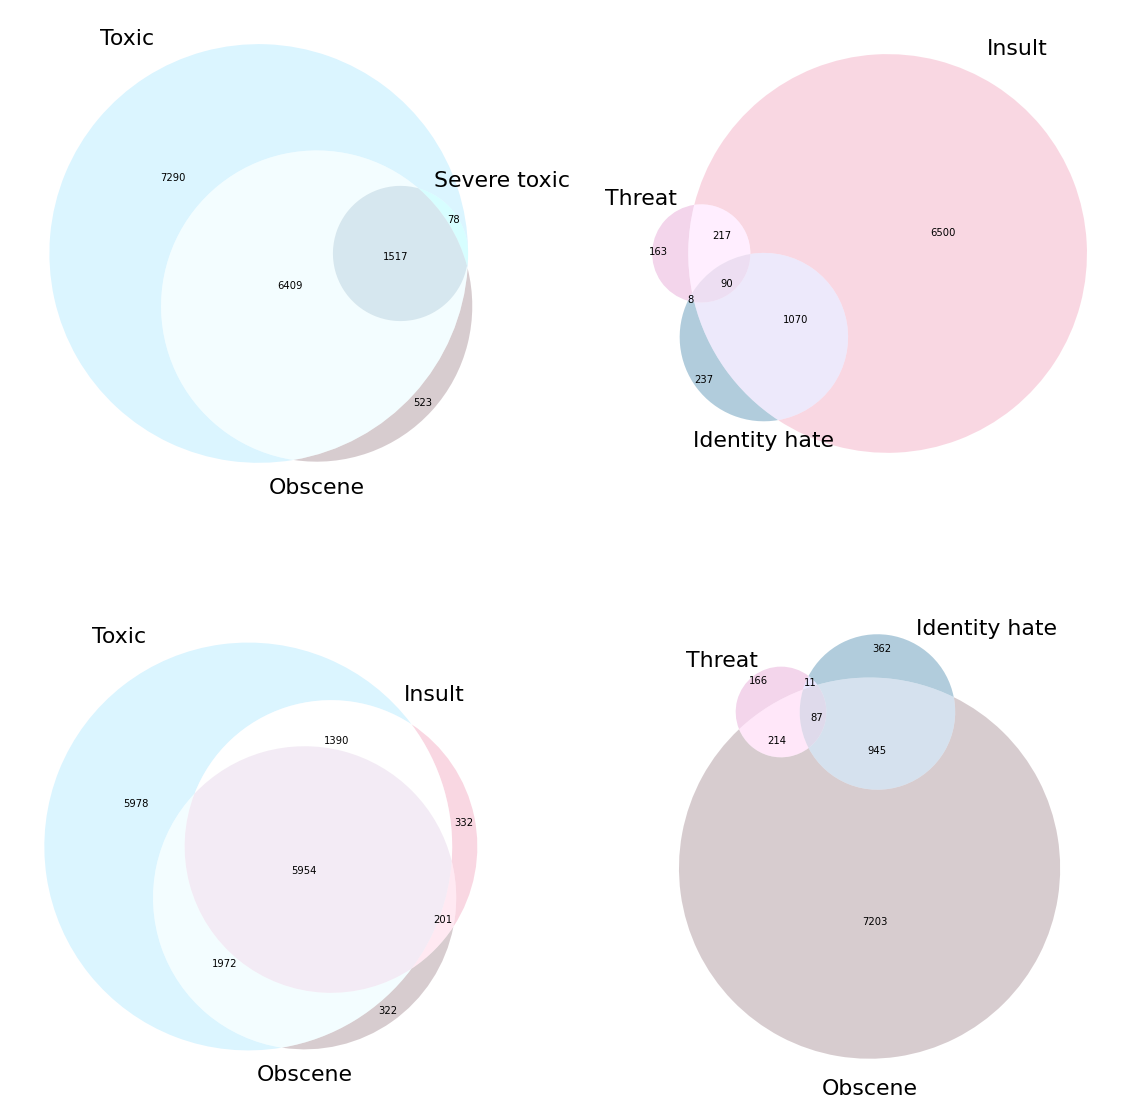

In [48]:
venn_(data)

### Doing Meta-data analysis
#### Comment length statistics across categories

- There is an observable difference between median length of clean and toxic data
- The difference in max text length and max distinct tokens raises suggests possibility of heavy word repetition

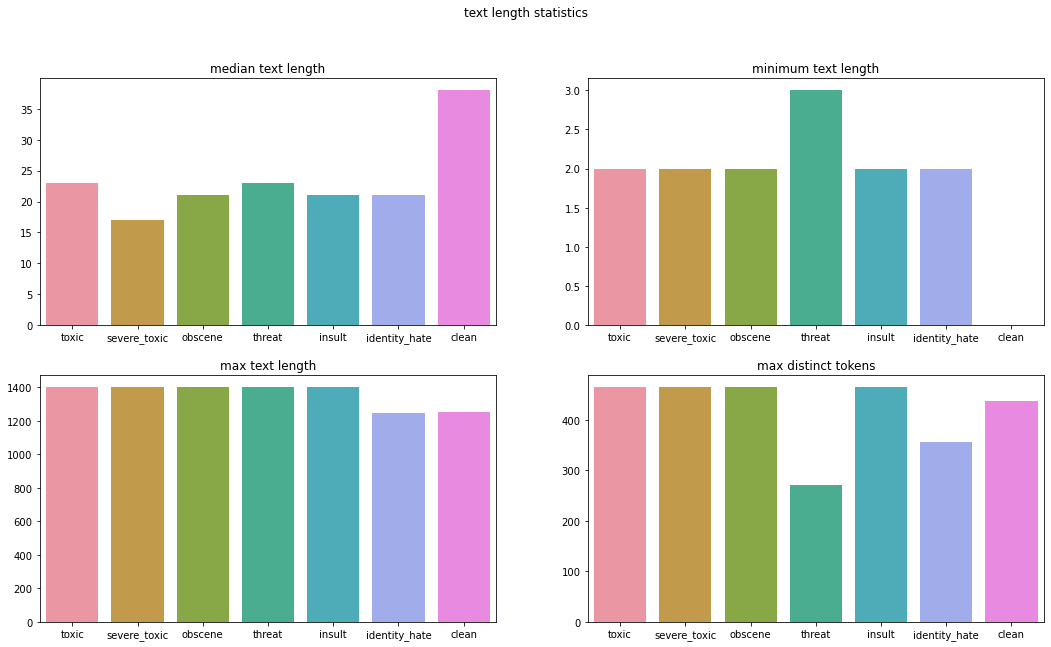

In [49]:
text_length_across_classes(data)

### Average word length in clean and toxic comments
- The average word length in both clean and toxic comments is unreasonbaly high; 
- we need to clean the data and inspect further, if the issue persists

clean comments max token length : 30.0


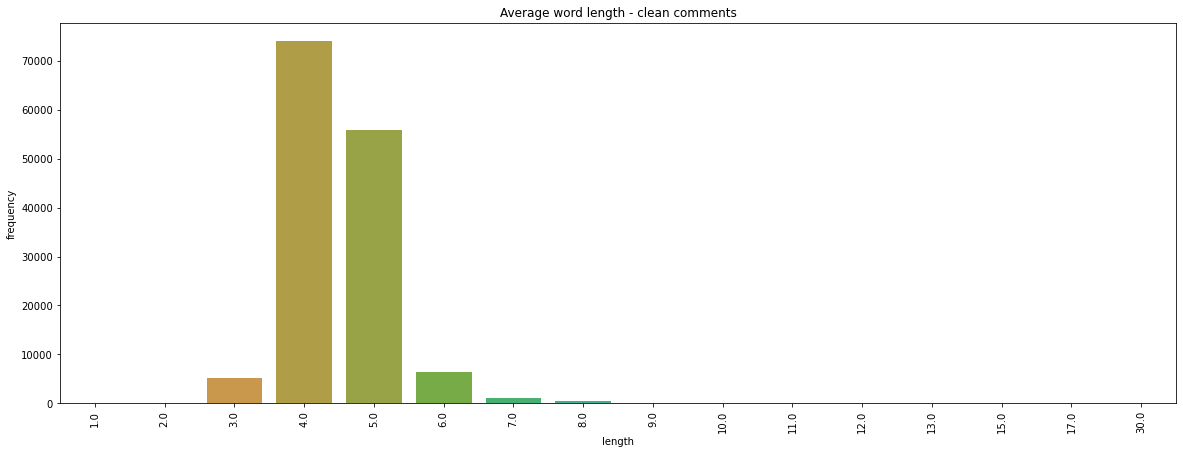

toxic comments max token length : 1240.0


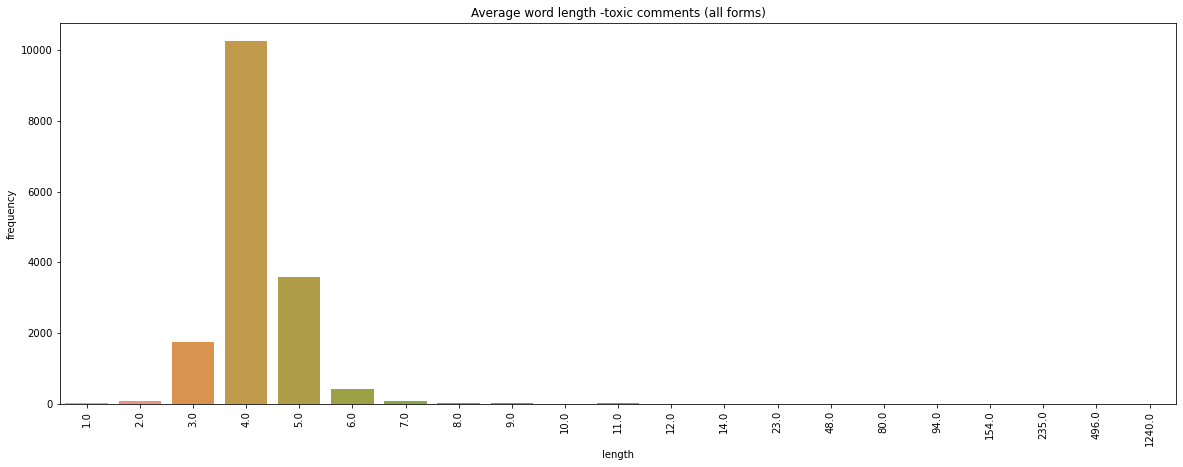

In [50]:
avg_word_len_plot(data)

In [51]:
category_text = data[data['clean']!=1]['comment_text'].values
category_text = " ".join(category_text)
long_len_words = [word for word in category_text.split() if len(word)>20]
print("num of long length words in toxic(all forms) text : {}".format(len(long_len_words)))
long_len_words[:5]

num of long length words in toxic(all forms) text : 392


['foreverlosttinkerbell',
 'encyclopediadramatica',
 'hahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaha',
 'lolololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololol',
 'cuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcuntcunti']

### Apart from the long token problem seen above, we have another issue
It is the issue of repetitive phrases/lines in comments
- Comments with text repetition can cause computational overload. 
- It's best to trim such text to its basic, non-repetitve form to preserve the meaning and also to make computation efficient.

sample text of the above nature in this dataset is as follows:

In [52]:
data[(data['comment_length']>100) & (data['distinct_tokens']<30)].comment_text.sample().values[0][:500]

'anthony bradbury sucks penis  anthony bradbury eats shit  anthony bradbury sucks penis  anthony bradbury eats shit  anthony bradbury sucks penis  anthony bradbury eats shit  anthony bradbury sucks penis  anthony bradbury eats shit  anthony bradbury sucks penis  anthony bradbury eats shit  anthony bradbury sucks penis  anthony bradbury eats shit  anthony bradbury sucks penis  anthony bradbury eats shit  anthony bradbury sucks penis  anthony bradbury eats shit  anthony bradbury sucks penis  anthon'

clean comments max token length : 30.0


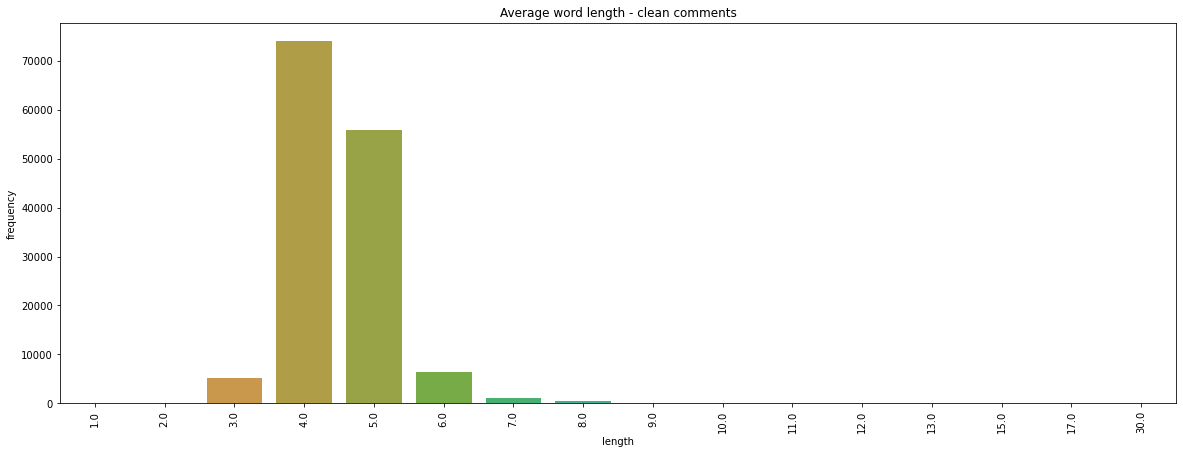

toxic comments max token length : 1240.0


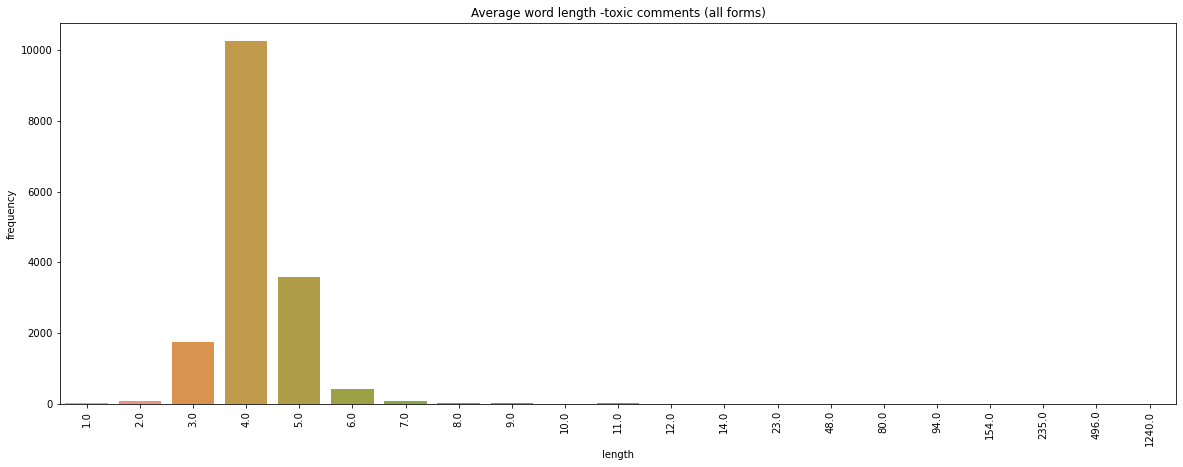

In [54]:
avg_word_len_plot(data)

## Bi-gram Analysis
- Most common bigrams in each category

In [55]:
def gram_analysis(data,gram):
    stop_words_set = set(stopwords.words('english'))
    tokens=[t for t in data.lower().split(" ") if t!="" if t not in stop_words_set]
    ngrams=zip(*[tokens[i:] for i in range(gram)])
    final_tokens=[" ".join(z) for z in ngrams]
    return final_tokens

In [56]:
def gram_freq(df, gram, categ_col, text_col):
    category_text = " ".join(df[df[categ_col]==1][text_col].sample(200).values)
    toks = gram_analysis(category_text, gram)
    tok_freq = pd.DataFrame(data=[toks, np.ones(len(toks))]).T.groupby(0).sum().reset_index()
    tok_freq.columns = ['token','frequency']
    tok_freq = tok_freq.sort_values(by='frequency',ascending=False)
    
    plt.figure(figsize=(15,8))
    plt.title("{} most common tokens".format(categ_col))
    sns.barplot(x='token', y='frequency', data=tok_freq.iloc[:30])
    plt.xticks(rotation=90)
    plt.show()
    
    return 

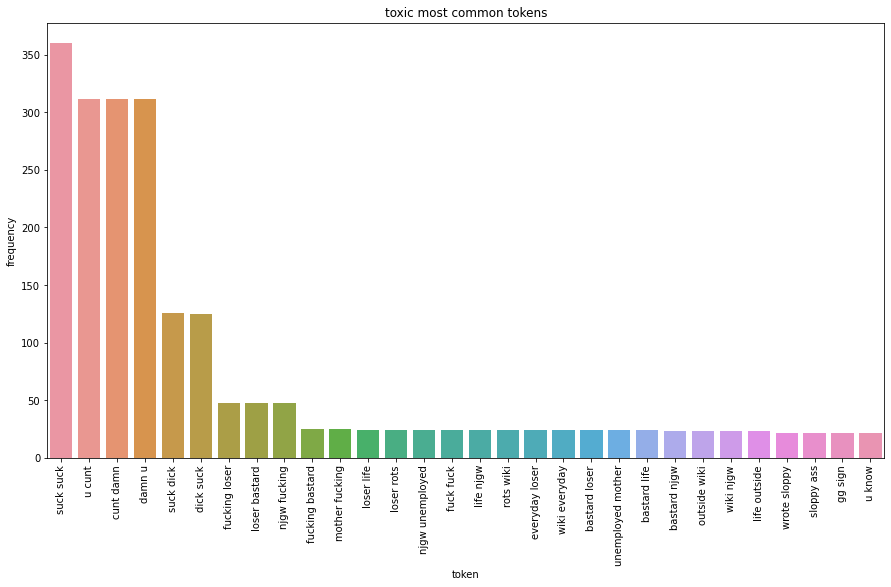

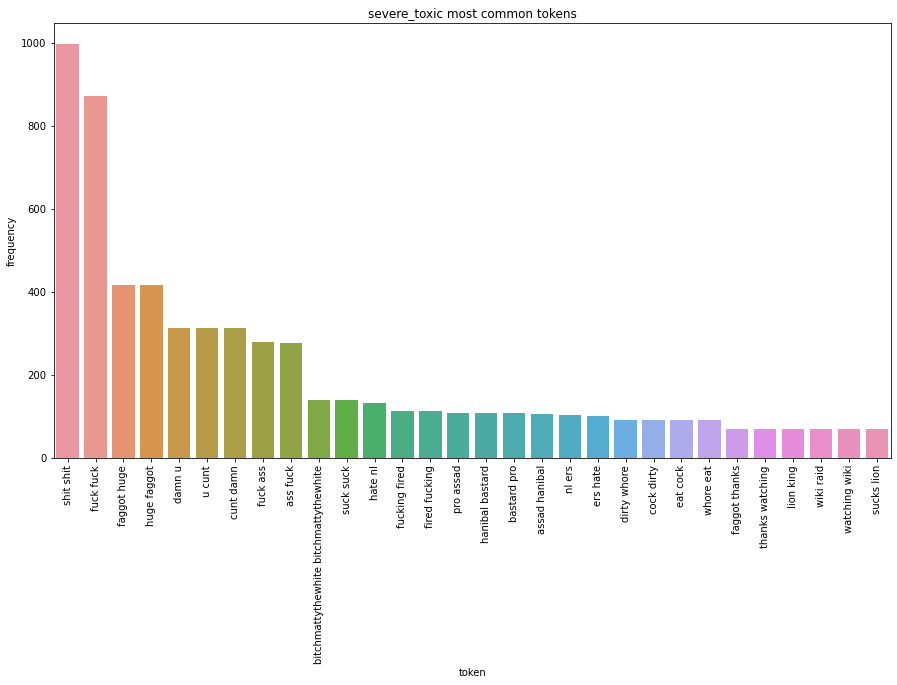

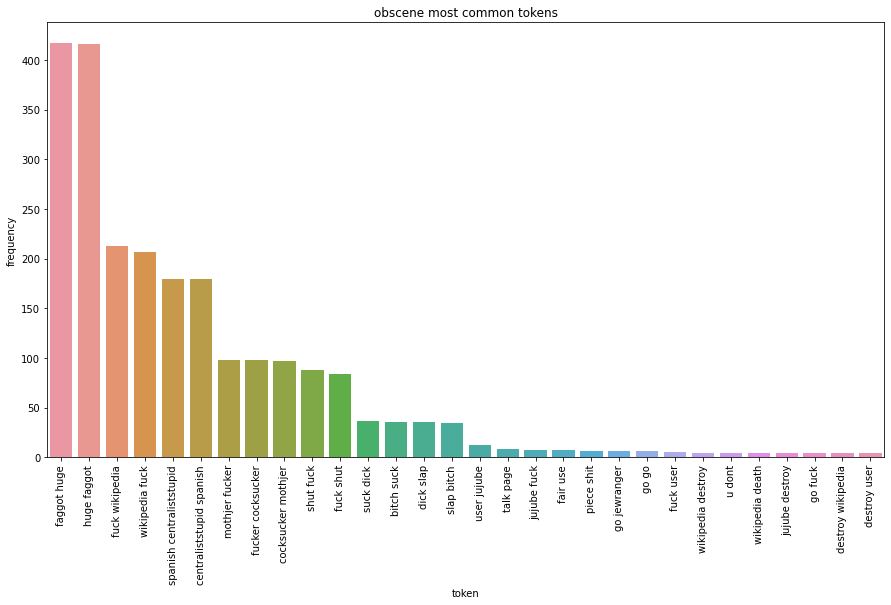

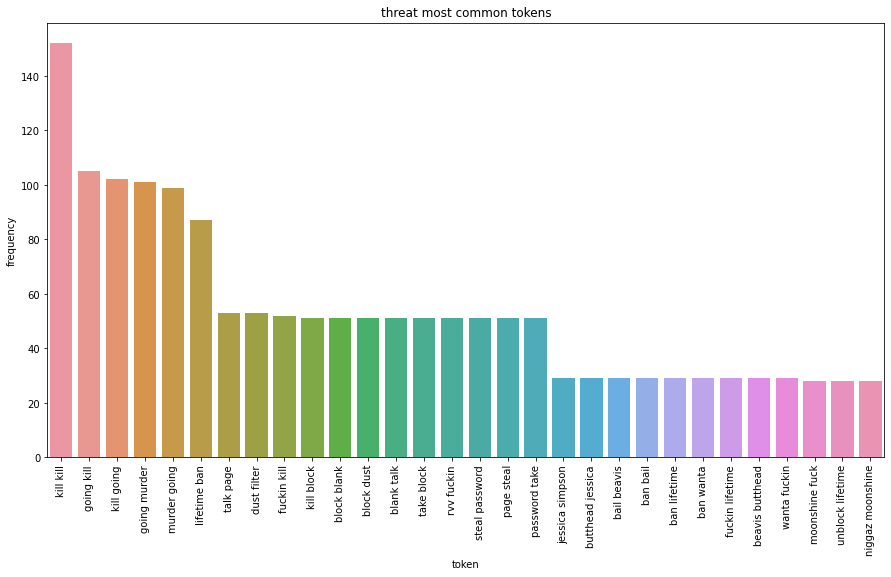

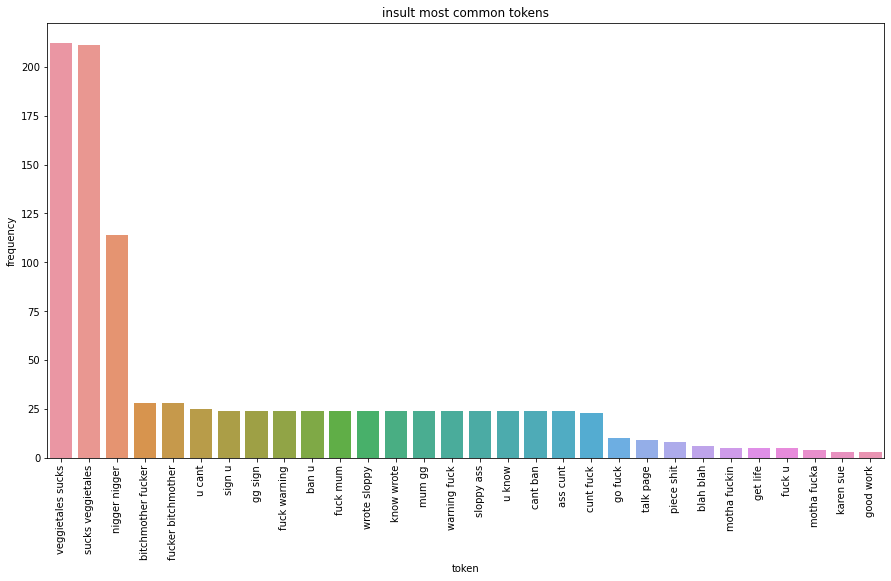

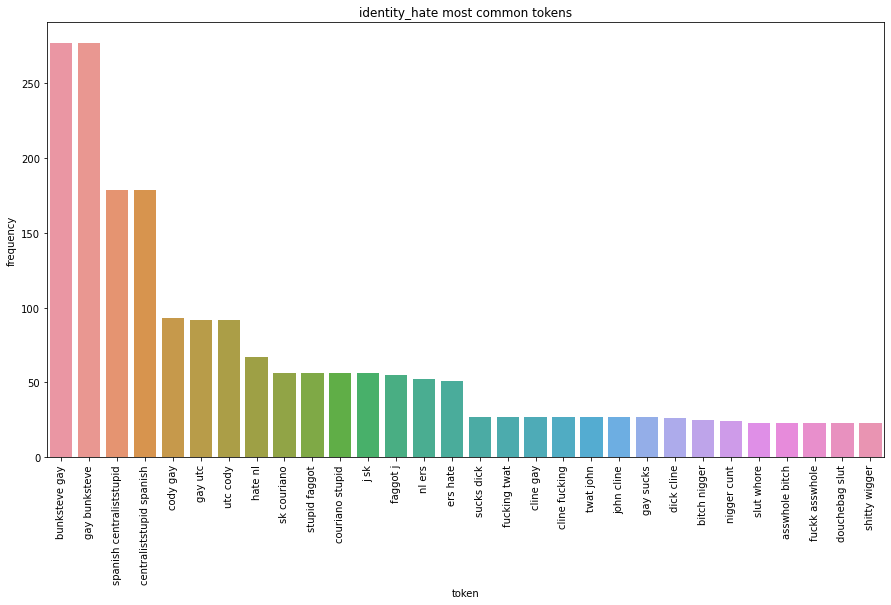

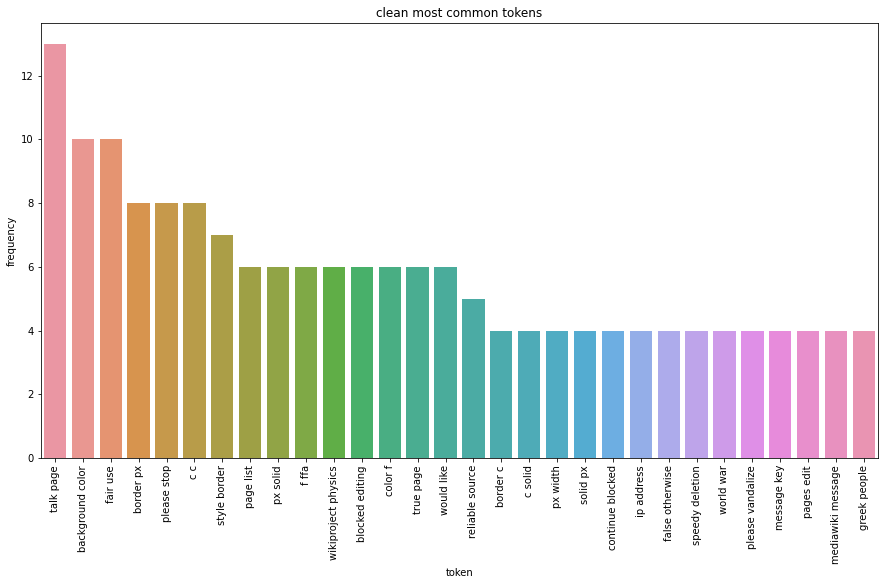

In [57]:
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']:
    gram_freq(data,2, i, 'comment_text')

## Tri-gram Analysis
- Most common trigrams in each category

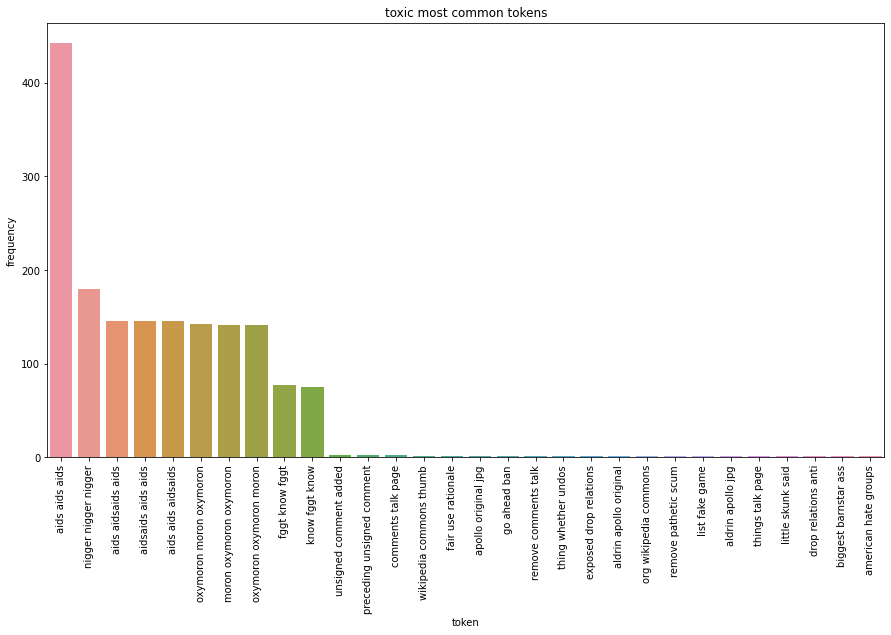

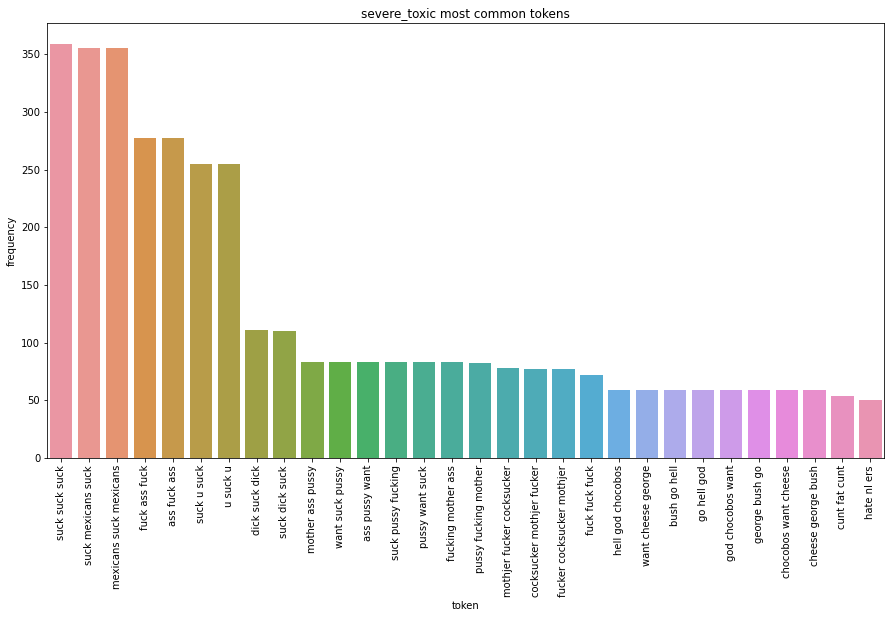

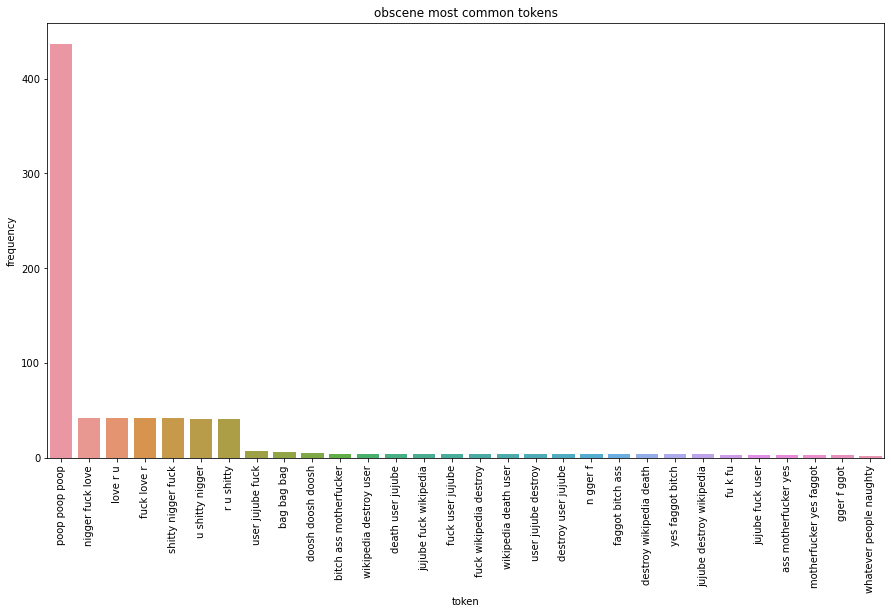

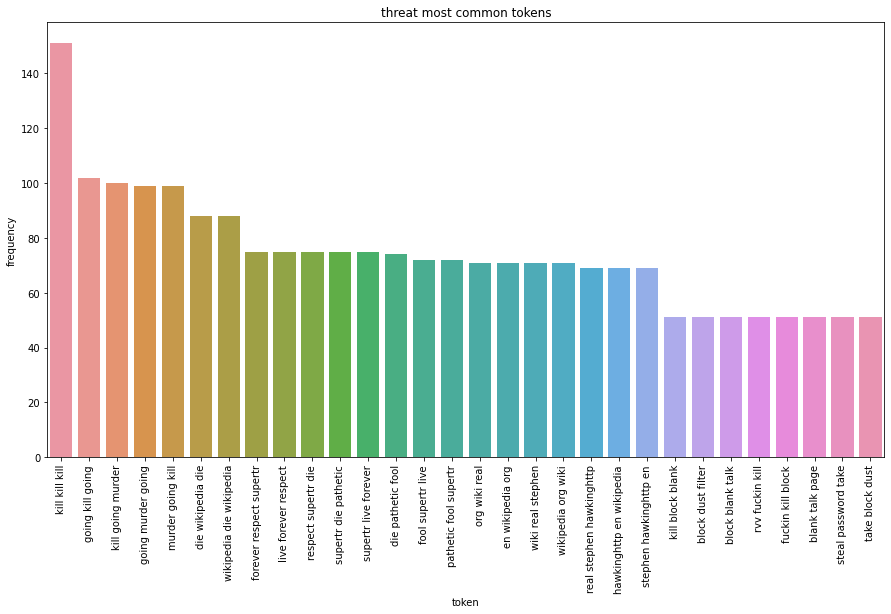

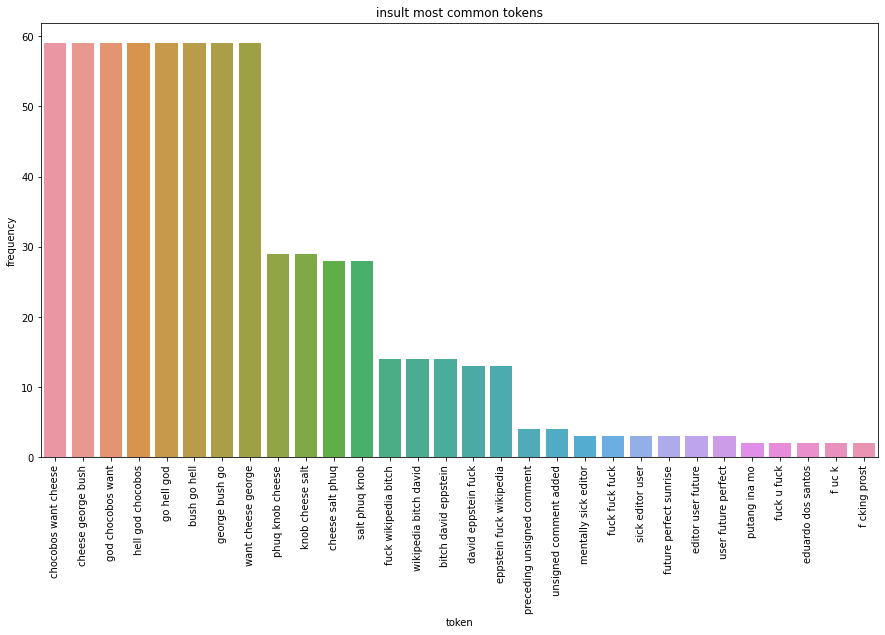

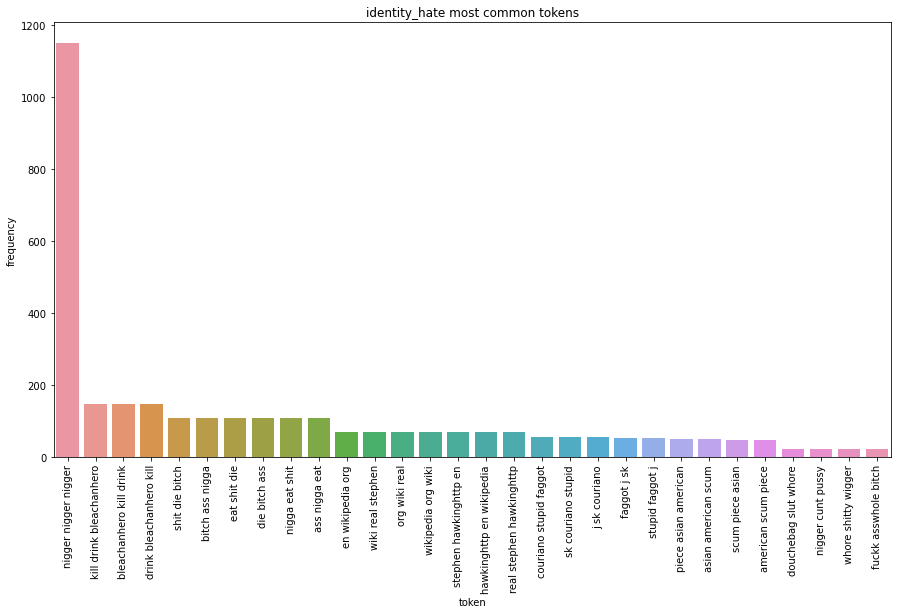

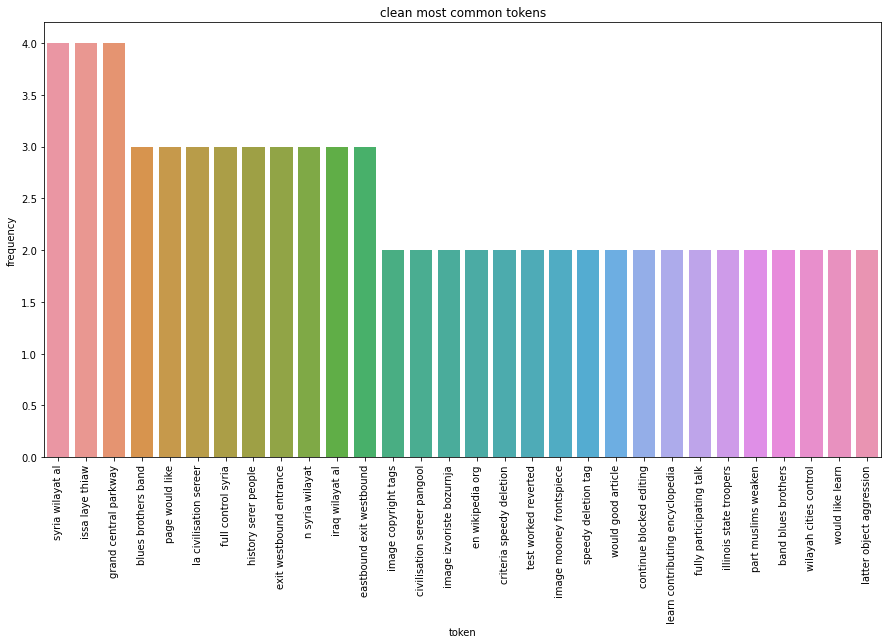

In [58]:
for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']:
    gram_freq(data,3, i, 'comment_text')

## From above EDA we can summarize:

1) The business problem is "Multi label problem" and not a "Binary".

2) Also all lebels are not independent but are rather dependent or correlated.

3) In our dataset a comment may be toxic, obscene and insulting at the same time. It may also happen that the comment is non-toxic and hence does not belong to any of the six labels.

## Let us simplify the problem by first classifying the comments as "block" vs "allow" 

In [59]:
data['block'] =data[cols_target].sum(axis =1)
print("                      ")

print(data['block'].value_counts())
data['block'] = data['block'] > 0 
data['block'] = data['block'].astype(int)
print("                      ")
print("Classifying the comments into Block Cs. Allow")
print(data['block'].value_counts())

                      
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: block, dtype: int64
                      
Classifying the comments into Block Cs. Allow
0    143346
1     16225
Name: block, dtype: int64


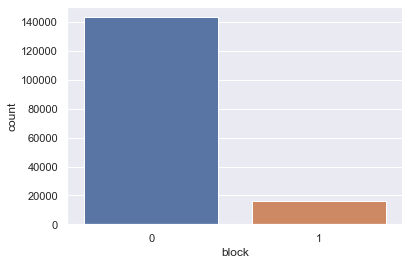

In [60]:
# look at the count plot for text length
sns.set()
sns.countplot(x="block" , data = data )
plt.show()

In [61]:
# Event Rate 

print("Percentage Event Rate : " , round(100*data['block'].sum()/data.shape[0],2) , "%")

Percentage Event Rate :  10.17 %


### Let us focus on comments  ###

In [62]:
# Let's look at the character length for the rows in the training data and record these
data['char_length'] = data['comment_text'].apply(lambda x: len(str(x)))

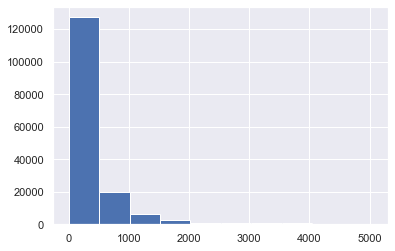

In [63]:
# look at the histogram plot for text length
sns.set()
data['char_length'].hist()
plt.show()

### Further Cleaning the Comments Text ###

In [64]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [65]:
%%time 
# clean the comment_text in train dataset
data['comment_text'] = data['comment_text'].map(lambda com : clean_text(com))

Wall time: 7.94 s


In [66]:
from sklearn.model_selection import train_test_split
# Splitting the Train Dataset in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(data['comment_text'], data['block'], test_size=0.2, random_state=42)

In [67]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(127656,) (31915,)
(127656,) (31915,)


### Import and Instantiate TfidfVectorizer
TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow us to encode new documents.

In [68]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features = 10000, stop_words='english')
#vect = TfidfVectorizer(stop_words='english')
print(vect)

TfidfVectorizer(max_features=10000, stop_words='english')


In [69]:
%%time 
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)
# examine the document-term matrix created from X_train
X_train_dtm

Wall time: 6.12 s


<127656x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2710462 stored elements in Compressed Sparse Row format>

In [70]:
X_train_dtm.shape

(127656, 10000)

In [71]:
100*2710462/ (127656*10000)

0.21232546844644984

In [72]:
%%time
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
X_test_dtm = vect.transform(X_test)
# examine the document-term matrix from X_test
X_test_dtm

Wall time: 1.37 s


<31915x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 667478 stored elements in Compressed Sparse Row format>

## Lets us build a binary classifier using Logistic Regression ##

In [73]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
logreg = LogisticRegression(C=1, max_iter = 2000)

# train the model using X_train_dtm & y_train
logreg.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = logreg.predict(X_train_dtm)
print("------------------------------------")
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
print("------------------------------------")
# compute the predicted probabilities for X_test_dtm
y_pred_test = logreg.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print("------------------------------------")
print("The Confusion Matrix")
print(confusion_matrix(y_test,y_pred_test))
print("------------------------------------")

------------------------------------
Training accuracy is 0.9598687096572037
------------------------------------
Test accuracy is 0.9564468118439605
------------------------------------
The Confusion Matrix
[[28497   174]
 [ 1216  2028]]
------------------------------------


In [74]:
#28497 -> comments  are good and predeicted as good 
#2028 -> comments are block and predicted as block
#174 -> comments are good but predicted as block
#1216 -> comments are block but predicted as good

In [82]:
#let is check the Accuracy entering the TP, TN, FP , FN manually from obtained from above step
(28497 + 2028)/(28497+2028+174+1216)

0.9564468118439605

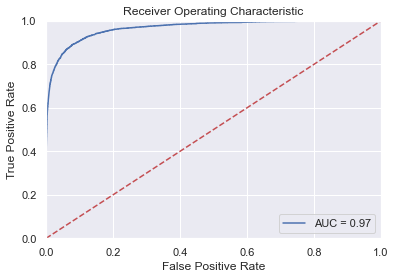

In [83]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test_dtm)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## the curse of Accuracy, F1(help) to rescue #

In [84]:
from sklearn.metrics import f1_score
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

F1 score on Test data :  0.7447668013220713


### In imbalanced data - we use F1 score as a general measure for the model performance ###

Depending on the Business case - we need to fine tune the model 

There is a Precision vs Recall Trade off 

If we try to capture all toxic comments  - then some of the good comments will be misclassified as bad comments 

In [85]:
y_pred_test = logreg.predict_proba(X_test_dtm)[:,1]
#print(y_pred_test)
y_pred_test = y_pred_test >= 0.2 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print("------------------------------------")
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print("------------------------------------")
print("The Confusion Matrix")
print(confusion_matrix(y_test,y_pred_test))
print("------------------------------------")
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))
print("------------------------------------")

------------------------------------
Test accuracy is 0.9519034936550211
------------------------------------
The Confusion Matrix
[[27783   888]
 [  647  2597]]
------------------------------------
F1 score on Test data :  0.7718828949323823
------------------------------------


# Let us use a tree base model

In [86]:
%%time 
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier 
dt_clf = DecisionTreeClassifier()
# train the model using X_train_dtm & y_train
dt_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = dt_clf.predict(X_train_dtm)
print("------------------------------------")
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = dt_clf.predict(X_test_dtm)
print("------------------------------------")
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print("------------------------------------")
print("The Confusion Matrix")
print(confusion_matrix(y_test,y_pred_test))
print("------------------------------------")
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))
print("------------------------------------")

------------------------------------
Training accuracy is 0.9987857993357148
------------------------------------
Test accuracy is 0.9425348582171392
------------------------------------
The Confusion Matrix
[[27799   872]
 [  962  2282]]
------------------------------------
F1 score on Test data :  0.7133479212253829
------------------------------------
Wall time: 4min 1s


### Lets us try an Ensemble of Trees

In [87]:
%%time 
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 

Wall time: 32.1 ms


In [88]:
rf_clf = RandomForestClassifier()

# train the model using X_train_dtm & y_train
rf_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = rf_clf.predict(X_train_dtm)
print("------------------------------------")
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = rf_clf.predict(X_test_dtm)
print("------------------------------------")
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print("------------------------------------")
print("The Confusion Matrix")
print(confusion_matrix(y_test,y_pred_test))
print("------------------------------------")
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))
print("------------------------------------")

------------------------------------
Training accuracy is 0.9987622986776963
------------------------------------
Test accuracy is 0.9576374745417515
------------------------------------
The Confusion Matrix
[[28307   364]
 [  988  2256]]
------------------------------------
F1 score on Test data :  0.7694406548431105
------------------------------------


In [89]:
# Fine Tuning Random Forest 

y_pred_test = rf_clf.predict_proba(X_test_dtm)[:,1]
y_pred_test = y_pred_test >= 0.05 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print("------------------------------------")
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print("------------------------------------")
print("The Confusion Matrix")
print(confusion_matrix(y_test,y_pred_test))
print("------------------------------------")
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))
print("------------------------------------")

------------------------------------
Test accuracy is 0.8107472975090083
------------------------------------
The Confusion Matrix
[[22821  5850]
 [  190  3054]]
------------------------------------
F1 score on Test data :  0.5027988146196904
------------------------------------


In [90]:
%%time
from sklearn.metrics import f1_score
from sklearn.linear_model  import PassiveAggressiveClassifier 

pa_clf = PassiveAggressiveClassifier()

# train the model using X_train_dtm & y_train
pa_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = pa_clf.predict(X_train_dtm)
print("------------------------------------")
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
print("------------------------------------")
# compute the predicted probabilities for X_test_dtm
y_pred_test = pa_clf.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print("------------------------------------")
print("The Confusion Matrix")
print(confusion_matrix(y_test,y_pred_test))
print("------------------------------------")
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))
print("------------------------------------")

------------------------------------
Training accuracy is 0.9757864886883499
------------------------------------
Test accuracy is 0.9532821557261476
------------------------------------
The Confusion Matrix
[[28061   610]
 [  881  2363]]
------------------------------------
F1 score on Test data :  0.7601737172269584
------------------------------------
Wall time: 472 ms


##### Passive Aggresive Classifier does not support prediction probability - so that it can't be fined 

In [91]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [92]:
%%time 
from sklearn.metrics import f1_score
import xgboost 

xgb = xgboost.XGBClassifier()
# train the model using X_train_dtm & y_train
xgb.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = xgb.predict(X_train_dtm)
print("------------------------------------")
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
print("------------------------------------")
# compute the predicted probabilities for X_test_dtm
y_pred_test = xgb.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print("------------------------------------")
print("The Confusion Matrix")
print(confusion_matrix(y_test,y_pred_test))
print("------------------------------------")
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))
print("------------------------------------")

[14:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------------------------
Training accuracy is 0.9609262392680329
------------------------------------
Test accuracy is 0.9546294845683848
------------------------------------
The Confusion Matrix
[[28510   161]
 [ 1287  1957]]
------------------------------------
F1 score on Test data :  0.7299515106303617
------------------------------------
Wall time: 54.4 s


#### Fine Tuning of XGBOOST

In [93]:
y_pred_test = xgb.predict_proba(X_test_dtm)[:,1]
y_pred_test = y_pred_test >= 0.06 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print("------------------------------------")
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print("------------------------------------")
print('The Confusion Matrix')
print(confusion_matrix(y_test,y_pred_test))
print("------------------------------------")
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))
print("------------------------------------")

------------------------------------
Test accuracy is 0.8829390568698104
------------------------------------
The Confusion Matrix
[[25331  3340]
 [  396  2848]]
------------------------------------
F1 score on Test data :  0.6039016115351993
------------------------------------


### Advance Models - LightGBM 
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

-Faster training speed and higher efficiency.
-Lower memory usage.
-Better accuracy.
-Support of parallel, distributed, and GPU learning.
-Capable of handling large-scale data.

In [94]:
import lightgbm 

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

train_data = lightgbm.Dataset(X_train_dtm, label=y_train)
test_data = lightgbm.Dataset(X_test_dtm, label=y_test)

clf = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=500,
                       early_stopping_rounds=10)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.429902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.767891
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.854147
[3]	valid_0's auc: 0.862946
[4]	valid_0's auc: 0.882034
[5]	valid_0's auc: 0.887347
[6]	valid_0's auc: 0.890588
[7]	valid_0's auc: 0.89108
[8]	valid_0's auc: 0.893133
[9]	valid_0's auc: 0.897381
[10]	valid_0's auc: 0.896405
[11]	valid_0's auc: 0.89618
[12]	valid_0's auc: 0.898139
[13]	valid_0's auc: 0.899951
[14]	valid_0's auc: 0.900439
[15]	valid_0's auc: 0.900661
[16]	val

#### Fine Tuning LIGHT GBM

In [95]:
y_pred_test = clf.predict(X_test_dtm)
y_pred_test = y_pred_test >= 0.35 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print("------------------------------------")
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print("------------------------------------")
print('The Confusion Matix')
print(confusion_matrix(y_test,y_pred_test))
print("------------------------------------")
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))
print("------------------------------------")

------------------------------------
Test accuracy is 0.9021463261789128
------------------------------------
The Confusion Matix
[[25890  2781]
 [  342  2902]]
------------------------------------
F1 score on Test data :  0.6501624285874315
------------------------------------


## Model Explanation

In [96]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [97]:
import eli5 
## ELI5  is used to inspect ML classifiers and explain their predictions.
## ELI5 understands text processing utilities from scikit-learn and can highlight text data accordingly.

eli5.show_weights(logreg,vec = vect, top = 10)  # logistic regression
# will give us top 10 features or words  which makes a comment toxic 

Weight?,Feature
+16.305,fuck
+13.305,fucking
+12.051,shit
+11.559,idiot
+10.883,stupid
+10.040,ass
+9.123,asshole
+8.906,bullshit
+8.712,suck
+8.598,bitch


In [98]:
eli5.show_weights(xgb,vec = vect,top = 10)  # XGBoost
# will give us top 10 features or words  which makes a comment toxic 

Weight,Feature
0.0273,fuck
0.0151,fucking
0.0125,loser
0.0125,bitch
0.0118,asshole
0.0116,faggot
0.0107,penis
0.0099,suck
0.0096,fag
0.0095,dick


## Comments Explanation ##

In [99]:
X_test.iloc[999]

'please consider this as a personal attack against the user node eu dear node eu i do take personal pride and honor to say to you and your commander an well deserved fuck you and yes i know as this moment your real identity please forgive me wikipedia i want to assure you and your family and this extend to the family of mr bortnikov that no harm intended or untended from me will occur it was a long process and some well spend money involved but i realize finally that you deserve only my mercy good look to you and yes wikipedia this is my last posting as i do realize that i have no place here i do much much better in the real scientific world'

In [101]:
eli5.show_prediction(logreg, vec = vect, doc =  X_test.iloc[999]) 